In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split


import regex as re
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

import warnings
warnings.filterwarnings('ignore')

from gensim import models

In [2]:
wvgn = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
wvwiki = models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec',encoding='latin')

print(wvgn.vectors.shape)
print(len(wvgn.vocab.keys()))
print(wvwiki.vectors.shape)
print(len(wvwiki.vocab.keys()))

(3000000, 300)
3000000
(999994, 300)
999994


In [3]:
lst_wvgn = list(set(wvgn.vocab.keys()))
lst_wvwiki = list(set(wvwiki.vocab.keys()))
print("lst_wvgn len:",len(lst_wvgn))
print("lst_wvwiki len:",len(lst_wvwiki))

lst_wvgn len: 3000000
lst_wvwiki len: 999994


In [4]:
unqwrds_embd = len(set(lst_wvgn+lst_wvwiki))
print("unqwrds_embd:",unqwrds_embd)

unqwrds_embd: 3495851


In [5]:
dfp3 = pd.read_csv('train.csv')
dfp3.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
# vocab in the data

cntvctr = CountVectorizer()
cntvctr.fit_transform(dfp3['question_text'])
lst_vcb = cntvctr.get_feature_names()
print(len(lst_vcb))

195000


In [8]:
vcb_cvrgcnt = len(set(lst_vcb).intersection(set(lst_wvgn+lst_wvwiki)))
print("vocab coverage:",vcb_cvrgcnt*100/len(lst_vcb))

vocab coverage: 49.69794871794872


In [9]:
# oov features 

vcb_ncvrd_lst = list(set(lst_vcb).difference(set(lst_wvgn+lst_wvwiki)))
print(len(vcb_ncvrd_lst))
print(vcb_ncvrd_lst)

98089
['codac', 'scadinavian', 'cmder', 'krupinski', 'southlands', 'aedis', 'trease', 'appia', 'farrukh', '_offset', 'pplanning', 'dimm', 'a_n', 'desemated', 'garmisch', 'doriath', 'kofuku', 'cjis', 'fxpro', 'myloma', 'graphicriver', 'badfinger', 'insapience', 'pharaceutical', 'shiquita', 'finkle', 'tadepalligudem', 'hamhung', 'mipt', 'ramis', 'purushpur', 'sharpey', 'vikrant', 'ltps', 'rur', 'moufti', 'hardwicke', 'mccullough', '2pege', 'agartala', 'satyamev', 'minijets', 'onepiecedeals', 'usefult', 'hyperlight', 'kisssing', 'exoensive', 'clixsense', 'meyerhold', 'compnoents', 'revoltech', 'datjobsoluction', 'tantive', 'huacachina', 'joylent', 'vidmate', '1x7', 'wespons', 'huemanity', 'schering', 'gargil', 'gopnik', 'remidies', 'narandra', 'dushyant', 'jeruselum', 'quanxi', 'dangeres', 'sukhrali', 'nanh2', 'valuea', 'urin', 'kapoors', 'daskal', 'busey', 'srikrishna', 'clsa', 'drpressed', 'quivea', 'estimatives', 'enggineering', 'ibrahimovich', 'doues', 'exterminatus', 'iitdmj', 'nilof

In [55]:
'''from textblob import TextBlob

def splcrtn(txt):
        textBlb = TextBlob(txt) 
        return textBlb.correct()
    
#dfp3['splchk_qtn'] = dfp3['question_text'].progress_apply(lambda x:splcrtn(x))    

In [41]:
# function to calculate embedding coverage % for each question
# input: question text
# output: returns coverage % of the question

st_embd = set(lst_wvgn+lst_wvwiki) # set of vocab in both embeddings

def txtcvrg(snt):
        snt1 = snt.split(" ") 
        ln1 = len(st_embd.intersection(set(snt1)))
        cvrg = np.ceil(ln1*100/len(snt1))
        return cvrg

In [13]:
dfp3['unprcsd_txtcvrg'] = dfp3['question_text'].progress_apply(lambda x:txtcvrg(x))

  0%|          | 0/1306122 [00:00<?, ?it/s]

In [15]:
dfp3['unprcsd_txtcvrg'].describe()

count    1.306122e+06
mean     8.391792e+01
std      7.805183e+00
min      0.000000e+00
25%      8.000000e+01
50%      8.600000e+01
75%      8.900000e+01
max      1.000000e+02
Name: unprcsd_txtcvrg, dtype: float64

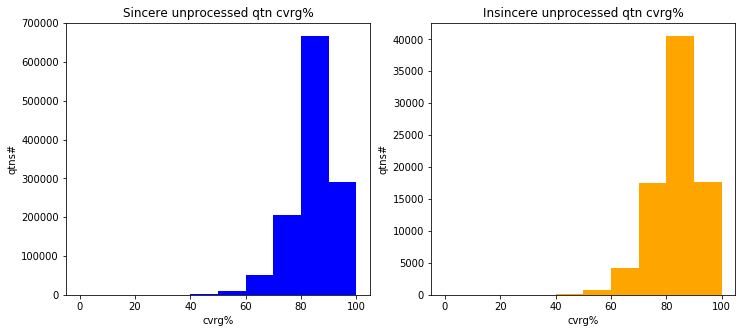

In [36]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(dfp3[dfp3['target']==0]['unprcsd_txtcvrg'],color="blue")
plt.xlabel("cvrg%")
plt.ylabel("qtns#")
plt.title("Sincere unprocessed qtn cvrg%")


plt.subplot(1,2,2)
plt.hist(dfp3[dfp3['target']==1]['unprcsd_txtcvrg'],color="orange")
plt.xlabel("cvrg%")
plt.ylabel("qtns#")
plt.title("Insincere unprocessed qtn cvrg%")

plt.show()

In [40]:
# function to process question text
# input: question text
# output: returns processed question test

#lemmatizer = WordNetLemmatizer()
#porter = PorterStemmer()


def prcstxt(snt):
    snt = str(snt).lower()
    snt = re.sub(r'can\'t',"can not",snt)
    snt = re.sub(r'haven\'t',"have not",snt)
    snt = re.sub(r'isn\'t',"is not",snt)
    snt = re.sub(r'aren\'t',"are not",snt)
    snt = re.sub(r'didn\'t',"did not",snt)
    snt = re.sub(r'don\'t',"do not",snt)
    snt = re.sub(r'wouldn\'t',"would not",snt)
    snt = re.sub(r'couldn\'t',"could not",snt)
    snt = re.sub(r'weren\'t',"were not",snt)
    snt = re.sub(r'n\'t'," not",snt)
    snt = re.sub(r'you\'re',"you are",snt)
    snt = re.sub(r'what\'s',"what is ",snt)
    snt = re.sub(r'\'s'," is ",snt)
    snt = re.sub(r'i\'m',"i am ",snt)
    snt = re.sub(r'[$€£₿ŁΞ¥₹]+'," money ",snt) 
    #snt = re.sub(r'\d+.\d+'," number " ,snt)
    #snt = re.sub(r'[\d+,\d+]+'," number ",snt)
    #snt = re.sub(r'\d+'," number ",snt)
    snt = re.sub(r'[?]+'," ? ",snt)
    snt = re.sub(r'[,]+'," , ",snt)
    snt = re.sub(r'[:]+'," : ",snt)
    snt = re.sub(r'[\"]+'," \" ",snt)
    snt = re.sub(r'[\']+'," ' ",snt)
    snt = re.sub(r'[(]+'," ( ",snt)
    snt = re.sub(r'[)]+'," ) ",snt)
    snt = re.sub(r'[[]+'," [ ",snt)
    snt = re.sub(r'[]]+'," ] ",snt)
    snt = re.sub(r'[{]+'," { ",snt)
    snt = re.sub(r'[{]+'," } ",snt)
    snt = re.sub(r'[\^]+'," ^ ",snt)
    snt = re.sub(r'[/]+'," / ",snt)
    snt = re.sub(r'[=]+'," = ",snt)
    snt = snt.strip()

    #sntp = " ".join([lemmatizer.lemmatize(wrd) for wrd in snt.split(" ")]) 
    #sntp = " ".join([porter.stem(wrd) for wrd in snt.split(" ")])

    return snt

In [17]:
dfp3['prcsd_txt'] = dfp3['question_text'].progress_apply(lambda x:prcstxt(x))

  0%|          | 0/1306122 [00:00<?, ?it/s]

In [23]:
dfp3['prcsd_txtcvrg'] = dfp3['prcsd_txt'].progress_apply(lambda x:txtcvrg(x))

  0%|          | 0/1306122 [00:00<?, ?it/s]

In [24]:
dfp3['prcsd_txtcvrg'].describe()

count    1.306122e+06
mean     9.196059e+01
std      9.701593e+00
min      0.000000e+00
25%      8.600000e+01
50%      9.400000e+01
75%      1.000000e+02
max      1.000000e+02
Name: prcsd_txtcvrg, dtype: float64

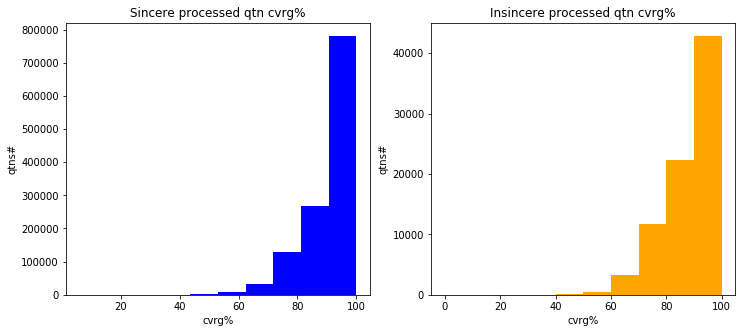

In [37]:

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(dfp3[dfp3['target']==0]['prcsd_txtcvrg'],color="blue")
plt.xlabel("cvrg%")
plt.ylabel("qtns#")
plt.title("Sincere processed qtn cvrg%")

plt.subplot(1,2,2)
plt.hist(dfp3[dfp3['target']==1]['prcsd_txtcvrg'],color="orange")
plt.xlabel("cvrg%")
plt.ylabel("qtns#")
plt.title("Insincere processed qtn cvrg%")

plt.show()

In [28]:
for i in range(0,110,10):
       #print(np.percentile(dfp3['txtcvrg'],i),"percentile of qtns are having",i,"embedding coverage")
        print("No.of qtns with <",i,"% embedding coverage",len(dfp3[dfp3['prcsd_txtcvrg']<i]))

No.of qtns with < 0 % embedding coverage 0
No.of qtns with < 10 % embedding coverage 5
No.of qtns with < 20 % embedding coverage 74
No.of qtns with < 30 % embedding coverage 289
No.of qtns with < 40 % embedding coverage 762
No.of qtns with < 50 % embedding coverage 2076
No.of qtns with < 60 % embedding coverage 8000
No.of qtns with < 70 % embedding coverage 37531
No.of qtns with < 80 % embedding coverage 154764
No.of qtns with < 90 % embedding coverage 440589
No.of qtns with < 100 % embedding coverage 707728


In [29]:
dfp3[dfp3['prcsd_txtcvrg']<70]['target'].value_counts()

0    33595
1     3936
Name: target, dtype: int64

(array([   3.,    5.,    6.,    4.,    6.,   28.,   57.,  204.,  831.,
        2792.]),
 array([ 0. ,  6.9, 13.8, 20.7, 27.6, 34.5, 41.4, 48.3, 55.2, 62.1, 69. ]),
 <a list of 10 Patch objects>)

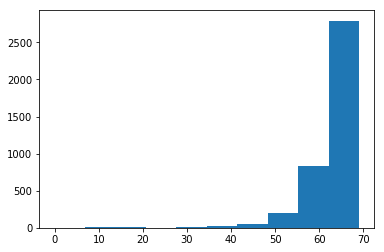

In [32]:
plt.hist(dfp3[(dfp3['prcsd_txtcvrg']<70) & (dfp3['target']==1)]['prcsd_txtcvrg'])

In [33]:
dfp3.head()

,qid,question_text,target,unprcsd_txtcvrg,prcsd_txt,prcsd_txtcvrg
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,93.0,how did quebec nationalists see their province...,100.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,82.0,"do you have an adopted dog , how would you en...",90.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,60.0,why does velocity affect time ? does velocity...,62.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,89.0,how did otto von guericke used the magdeburg h...,80.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,87.0,can i convert montra helicon d to a mountain b...,94.0


In [42]:
dfp3.to_csv("qis_prcsdtxt_df.csv",index=False)

In [43]:
dfrd = pd.read_csv("qis_prcsdtxt_df.csv")
dfrd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 6 columns):
qid                1306122 non-null object
question_text      1306122 non-null object
target             1306122 non-null int64
unprcsd_txtcvrg    1306122 non-null float64
prcsd_txt          1306122 non-null object
prcsd_txtcvrg      1306122 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 59.8+ MB


In [44]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(dfp3['prcsd_txt'], dfp3['target'], dfp3.index , test_size=0.33, stratify=dfp3['target'])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(875101,)
(875101,)
(431021,)
(431021,)


In [51]:
tfidfvctr = TfidfVectorizer(stop_words="english",ngram_range=(2,2)) #,max_features=10000)
X_train_tfvctr = tfidfvctr.fit_transform(X_train)
X_test_tfvctr = tfidfvctr.transform(X_test)
print(X_train_tfvctr.shape)
print(X_test_tfvctr.shape)


(875101, 2534171)
(431021, 2534171)


In [65]:
# function to calculate probability threshold 
# input: true test labels , predicted probabilities of class 1
# output: f1,threshold

from sklearn.metrics import precision_recall_curve

def thrshld(ytst,yprob):
    precision, recall, thresholds = precision_recall_curve(ytst, yprob)

    f1 = 2 * precision *  recall / ( precision + recall)
    #print("f1 argmax:",np.argmax(f1))
    thrshld = thresholds[np.argmax(f1)]

    #print("max f1:",max(f1))
    #print("threshold:",thresholds[np.argmax(f1)])
    
    return f1,thrshld

#### Basic LR Model (Tfidf-Bigrams-Default Model Params)

In [53]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_tfvctr, y_train)

LogisticRegression()

In [64]:
y_pred_prob_lr = lr.predict_proba(X_test_tfvctr)[:,1]
#print("y_pred_prob_lr:",y_pred_prob_lr[0:10])


In [66]:
maxf1,lr_thrshld = thrshld(y_test,y_pred_prob_lr)
print("lr_thrshld:",lr_thrshld)
print("f1:",max(maxf1))

y_pred_lbs_lr = (y_pred_prob_lr>=lr_thrshld).astype('int')
#print("y_pred_lbs_lr:",y_pred_lbs_lr)

lr_thrshld: 0.0995255218306583
f1: 0.4537069719617563


In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lbs_lr, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96    404354
           1       0.38      0.55      0.45     26667

    accuracy                           0.92    431021
   macro avg       0.68      0.75      0.70    431021
weighted avg       0.93      0.92      0.92    431021

